# **DOWNLOAD DATA**

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1F2yrJB-RpIK87kXQn5dh61WeIDDSYvKv" -O kendaraan_train.csv

--2021-04-17 13:00:52--  https://drive.google.com/uc?export=download&id=1F2yrJB-RpIK87kXQn5dh61WeIDDSYvKv
Resolving drive.google.com (drive.google.com)... 74.125.139.113, 74.125.139.138, 74.125.139.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.139.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sqjdc78ud6o5qkspiaa0ltq170l0fri4/1618664400000/16386755940020632228/*/1F2yrJB-RpIK87kXQn5dh61WeIDDSYvKv?e=download [following]
--2021-04-17 13:00:53--  https://doc-0s-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sqjdc78ud6o5qkspiaa0ltq170l0fri4/1618664400000/16386755940020632228/*/1F2yrJB-RpIK87kXQn5dh61WeIDDSYvKv?e=download
Resolving doc-0s-1g-docs.googleusercontent.com (doc-0s-1g-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::84
Connecting to doc-0s-1g-docs.googleusercontent.com (doc-0s

# **LIBRARY**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import copy
from sklearn.metrics.pairwise import euclidean_distances

# **READ CSV**

In [ ]:
df_train = pd.read_csv('kendaraan_train.csv')

In [ ]:
df_train.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


# **DATA EXPLORATION**

In [ ]:
X = df_train.drop(['id', 'SIM', 'Sudah_Asuransi', 'Jenis_Kelamin', 'Umur_Kendaraan', 'Kendaraan_Rusak', 'Tertarik'], axis=1)
# X.replace({
#     'Jenis_Kelamin': {'Wanita': 0, 'Pria': 1},
#     'Umur_Kendaraan': {'< 1 Tahun': 0, '1-2 Tahun': 1, '> 2 Tahun': 2},
#     'Kendaraan_Rusak': {'Tidak': 0, 'Pernah': 1}
# }, inplace=True)

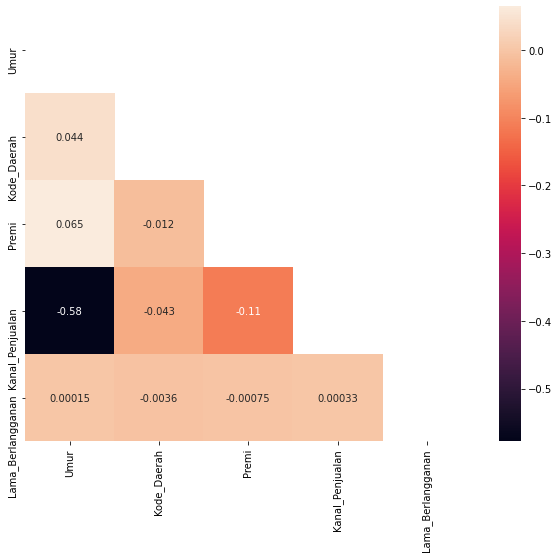

In [ ]:
corr_X = X.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_X, dtype=bool))
sns.heatmap(corr_X, annot=True, mask=mask)

## **FEATURE SELECTION**

In [ ]:
columns = np.full((corr_X.shape[0],), True, dtype=bool)
for i in range(corr_X.shape[0]):
    for j in range(i+1, corr_X.shape[0]):
        if corr_X.iloc[i,j] >= 0.3:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X_t1 = X[selected_columns]
X_t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285831 entries, 0 to 285830
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur               271617 non-null  float64
 1   Kode_Daerah        271525 non-null  float64
 2   Premi              271262 non-null  float64
 3   Kanal_Penjualan    271532 non-null  float64
 4   Lama_Berlangganan  271839 non-null  float64
dtypes: float64(5)
memory usage: 10.9 MB


In [ ]:
X_t1 = X[['Umur', 'Kanal_Penjualan']]

# **PRE-PROCESSING**

## **MISSING VALUES**

In [ ]:
X_t1.isna().sum()

Umur               14214
Kanal_Penjualan    14299
dtype: int64

In [ ]:
X_train = X_t1.dropna()
X_train.isna().sum()

Umur               0
Kanal_Penjualan    0
dtype: int64

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258007 entries, 0 to 285830
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Umur             258007 non-null  float64
 1   Kanal_Penjualan  258007 non-null  float64
dtypes: float64(2)
memory usage: 5.9 MB


## **OUTLIERS**

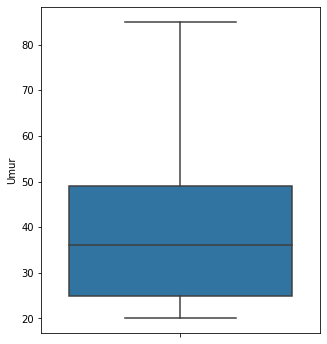

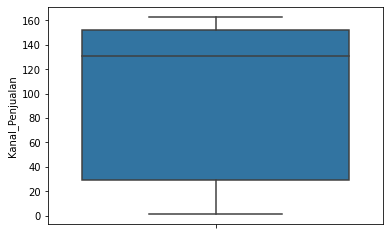

In [ ]:
plt.figure(figsize=(5, 6))

for i in X_train.columns:
  sns.boxplot(
      data=X_train,
      y=i
  )
  plt.show()

## **SCALING**

In [ ]:
X_train_sample = X_train.sample(5000)
# X_train_sample = X_train

scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(X_train_sample)
X_train_

array([[0.21311475, 0.92592593],
       [0.47540984, 0.15432099],
       [0.09836066, 0.93209877],
       ...,
       [0.08196721, 0.93209877],
       [0.29508197, 0.07407407],
       [0.62295082, 0.15432099]])

In [ ]:
np.savetxt("MinMax.csv", X_train_, delimiter=",")

# **MODELLING**

## **FUNCTIONS**

In [ ]:
def findClosestCentroids(ic, X):
    assigned_centroid = []
    for i in X:
        distance=[]
        for j in ic:
            distance.append(np.linalg.norm(i - j))
        assigned_centroid.append(np.argmin(distance))
    return assigned_centroid

def calc_centroids(clusters, X):
    new_centroids = []
    new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])], axis=1)
    for c in set(new_df['cluster']):
        current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
        cluster_mean = current_cluster.mean()
        new_centroids.append(cluster_mean)
    return new_centroids

def init_centroid(X, n_cluster):
  init_centroids = random.sample(range(len(X)), n_cluster)
  centroids = [X[i] for i in init_centroids]
  return centroids

In [ ]:
def fit(X, n_cluster):
  centroids = init_centroid(X, n_cluster)
  centroid = [np.zeros(i.shape[0]) for i in centroids]
  comparison = np.array(centroid) == np.array(centroids)

  while comparison.all() == False:
    get_centroids = findClosestCentroids(centroids, X)
    centroid = centroids.copy()
    centroids = np.array(calc_centroids(get_centroids, X))
    comparison = np.array(centroid) == np.array(centroids)
  
  cluster = [[] for _ in range(len(set(get_centroids)))]
  for i, j in enumerate(get_centroids):
    cluster[j].append(X[i])

  return get_centroids, centroids, cluster

In [ ]:
def inertia_(centroid, cluster):
  cluster_sum_of_squares_points_to_clusters = 0

  for i in range(len(centroid)):

      for cluster_point in cluster[i]:
          euclidean_norm_distance = np.linalg.norm(cluster_point - centroid[i])
          euclidean_norm_distance_squared = euclidean_norm_distance**2

          cluster_sum_of_squares_points_to_clusters += euclidean_norm_distance_squared
      
  return cluster_sum_of_squares_points_to_clusters

## **BEFORE CLUSTERING**

Text(0, 0.5, 'Kanal_Penjualan')

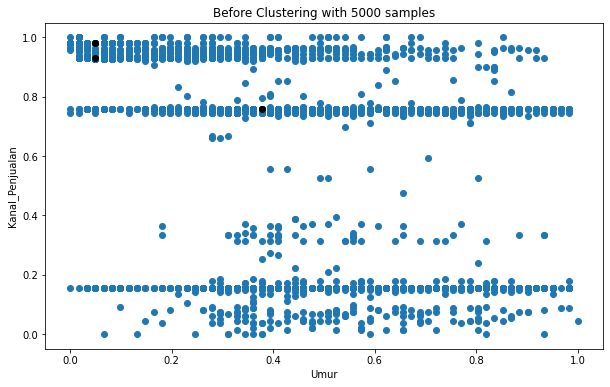

In [ ]:
array_centroid = init_centroid(X_train_, 3)
get_centroids = findClosestCentroids(array_centroid, X_train_)
X_train_copy = X_train_sample.copy()
X_train_copy['Label'] = get_centroids

plt.figure(figsize=(10, 6))
plt.scatter(
    X_train_[:, 0],
    X_train_[:, 1],
)
for i in range(len(array_centroid)):
  plt.scatter(
      array_centroid[i][0],
      array_centroid[i][1],
      c='black'
  )

plt.title('Before Clustering with 5000 samples')
plt.xlabel(X_train_sample.columns[0])
plt.ylabel(X_train_sample.columns[1])

## **AFTER CLUSTERING**

Text(0, 0.5, 'Kanal_Penjualan')

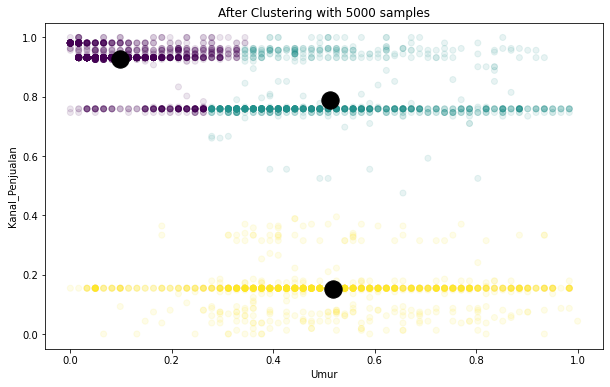

In [ ]:
get_centroids, array_centroid, array_cluster = fit(X_train_, 3)
plt.figure(figsize=(10, 6))
plt.scatter(
    array_centroid[:, 0],
    array_centroid[:, 1],
    color='black',
    zorder=2,
    s=300
)
plt.scatter(
    X_train_[:, 0],
    X_train_[:, 1],
    alpha=.1,
    c=get_centroids
)
plt.title('After Clustering with 5000 samples')
plt.xlabel(X_train_sample.columns[0])
plt.ylabel(X_train_sample.columns[1])

# **EVALUATION**

Text(0.5, 0, 'Number of cluster')

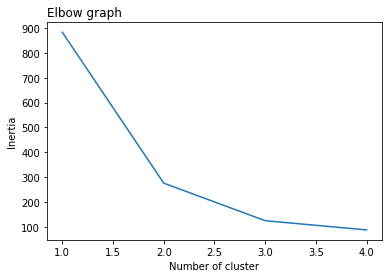

In [ ]:
clusters = []
for i in range(1, 5):
  get_centroids, array_centroid, array_cluster = fit(X_train_, i)
  clusters.append(inertia_(array_centroid, array_cluster))

plt.plot(
    range(1, 5),
    clusters
)
plt.title('Elbow graph', loc='left')
plt.ylabel('Inertia')
plt.xlabel('Number of cluster')

Text(0, 0.5, 'Kanal_Penjualan')

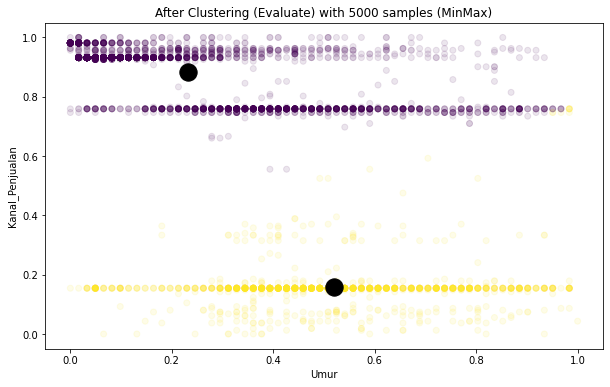

In [ ]:
get_centroids, array_centroid, array_cluster = fit(X_train_, 2)
plt.figure(figsize=(10, 6))
plt.scatter(
    np.array(array_centroid)[:, 0],
    np.array(array_centroid)[:, 1],
    color='black',
    zorder=2,
    s=300
)
plt.scatter(
    X_train_[:, 0],
    X_train_[:, 1],
    alpha=.1,
    c=get_centroids
)

plt.title('After Clustering (Evaluate) with 5000 samples (MinMax)')
plt.xlabel(X_train_sample.columns[0])
plt.ylabel(X_train_sample.columns[1])

# **EXPERIMENT**

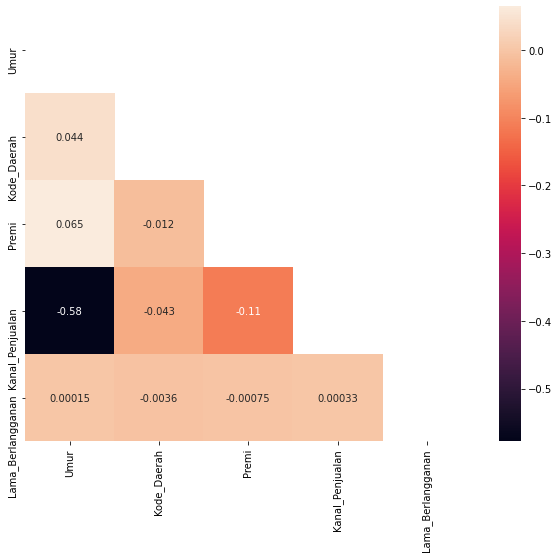

In [ ]:
corr_X = X.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_X, dtype=bool))
sns.heatmap(corr_X, annot=True, mask=mask)

In [ ]:
columns = np.full((corr_X.shape[0],), True, dtype=bool)
for i in range(corr_X.shape[0]):
    for j in range(i+1, corr_X.shape[0]):
        if corr_X.iloc[i,j] >= 0.3:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X_t2 = X[selected_columns]
X_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285831 entries, 0 to 285830
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur               271617 non-null  float64
 1   Kode_Daerah        271525 non-null  float64
 2   Premi              271262 non-null  float64
 3   Kanal_Penjualan    271532 non-null  float64
 4   Lama_Berlangganan  271839 non-null  float64
dtypes: float64(5)
memory usage: 10.9 MB


In [ ]:
X_t2 = X[['Umur', 'Kanal_Penjualan']]

In [ ]:
X_t2.isna().sum()

Umur               14214
Kanal_Penjualan    14299
dtype: int64

In [ ]:
X_train = X_t2.dropna()
X_train.isna().sum()

Umur               0
Kanal_Penjualan    0
dtype: int64

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258007 entries, 0 to 285830
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Umur             258007 non-null  float64
 1   Kanal_Penjualan  258007 non-null  float64
dtypes: float64(2)
memory usage: 5.9 MB


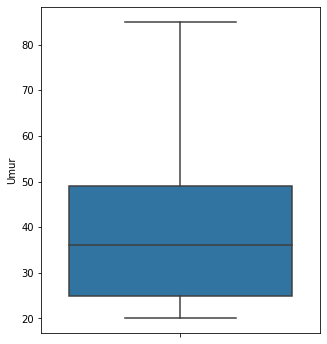

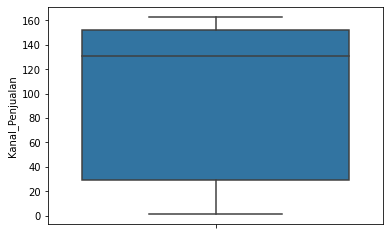

In [ ]:
plt.figure(figsize=(5, 6))

for i in X_train.columns:
  sns.boxplot(
      data=X_train,
      y=i
  )
  plt.show()

In [ ]:
X_train_sample = X_train.sample(5000)
# X_train_sample = X_train

# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train_sample)
X_train_

array([[-0.56618209,  0.74238647],
       [ 0.52235872,  0.22750434],
       [ 0.39429509,  0.22750434],
       ...,
       [ 0.71445415,  0.8343297 ],
       [-0.95037296,  0.74238647],
       [-1.1424684 ,  0.88949564]])

In [ ]:
np.savetxt("Standard.csv", X_train_, delimiter=",")

Text(0, 0.5, 'Kanal_Penjualan')

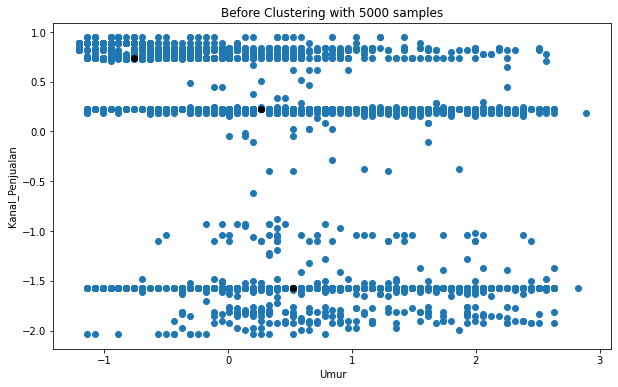

In [ ]:
array_centroid = init_centroid(X_train_, 3)
get_centroids = findClosestCentroids(array_centroid, X_train_)
X_train_copy = X_train_sample.copy()
X_train_copy['Label'] = get_centroids

plt.figure(figsize=(10, 6))
plt.scatter(
    X_train_[:, 0],
    X_train_[:, 1],
)
for i in range(len(array_centroid)):
  plt.scatter(
      array_centroid[i][0],
      array_centroid[i][1],
      c='black'
  )

plt.title('Before Clustering with 5000 samples')
plt.xlabel(X_train_sample.columns[0])
plt.ylabel(X_train_sample.columns[1])

Text(0, 0.5, 'Kanal_Penjualan')

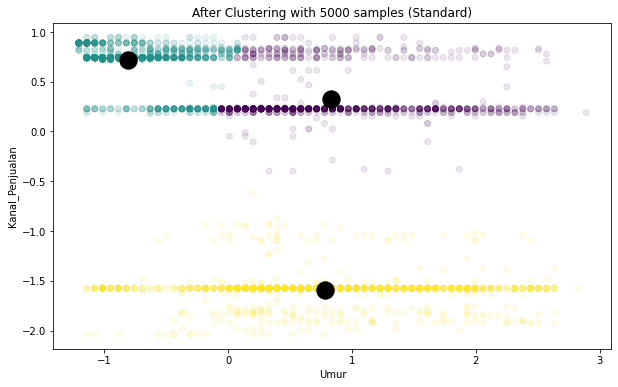

In [ ]:
get_centroids, array_centroid, array_cluster = fit(X_train_, 3)
plt.figure(figsize=(10, 6))
plt.scatter(
    array_centroid[:, 0],
    array_centroid[:, 1],
    color='black',
    zorder=2,
    s=300
)
plt.scatter(
    X_train_[:, 0],
    X_train_[:, 1],
    alpha=.1,
    c=get_centroids
)
plt.title('After Clustering with 5000 samples (Standard)')
plt.xlabel(X_train_sample.columns[0])
plt.ylabel(X_train_sample.columns[1])

Text(0.5, 0, 'Number of cluster')

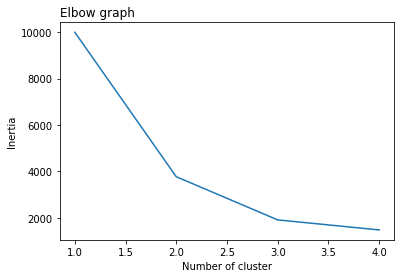

In [ ]:
clusters = []
for i in range(1, 5):
  get_centroids, array_centroid, array_cluster = fit(X_train_, i)
  clusters.append(inertia_(array_centroid, array_cluster))

plt.plot(
    range(1, 5),
    clusters
)
plt.title('Elbow graph', loc='left')
plt.ylabel('Inertia')
plt.xlabel('Number of cluster')

Text(0, 0.5, 'Kanal_Penjualan')

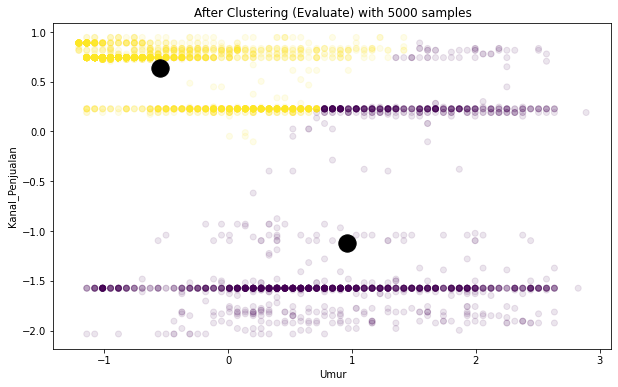

In [ ]:
get_centroids, array_centroid, array_cluster = fit(X_train_, 2)
plt.figure(figsize=(10, 6))
plt.scatter(
    np.array(array_centroid)[:, 0],
    np.array(array_centroid)[:, 1],
    color='black',
    zorder=2,
    s=300
)
plt.scatter(
    X_train_[:, 0],
    X_train_[:, 1],
    alpha=.1,
    c=get_centroids
)

plt.title('After Clustering (Evaluate) with 5000 samples')
plt.xlabel(X_train_sample.columns[0])
plt.ylabel(X_train_sample.columns[1])